In [1]:
# Install required packages
# Run this cell first if you haven't already installed these packages

import sys
import subprocess

def install_package(package):
    """Install a package using pip"""
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# List of required packages
required_packages = [
    'gymnasium',           # Reinforcement learning environments (CartPole)
    'numpy',              # Numerical computing
    'matplotlib',         # Plotting and visualization

]

print("Checking and installing required packages...")
print("=" * 60)

for package in required_packages:
    try:
        __import__(package.split('[')[0])  # Handle packages with extras like 'package[extra]'
        print(f"✓ {package} already installed")
    except ImportError:
        print(f"Installing {package}...")
        install_package(package)
        print(f"✓ {package} installed successfully")

print("=" * 60)
print("All required packages are installed!")
print("\nYou can now run the rest of the notebook.")

Checking and installing required packages...
✓ gymnasium already installed
✓ numpy already installed
✓ matplotlib already installed
All required packages are installed!

You can now run the rest of the notebook.


In [2]:
# Configure matplotlib for Google Colab (prevents flashing)
import matplotlib.pyplot as plt
%matplotlib inline
plt.ion()  # Turn on interactive mode

print("✓ Matplotlib configured for smooth updates in Google Colab")

✓ Matplotlib configured for smooth updates in Google Colab


# CartPole PID Control with Genetic Algorithm

## What You're Actually Doing Here

Look, you've got a cart with a pole on it. The pole wants to fall over. Your job is to tune a PID controller so it doesn't. Simple, right? Wrong. Tuning PID controllers manually is a pain in the ass - you tweak one parameter, something improves, then two other things break.

So instead of spending hours doing that, we're letting evolution do the work. That's what genetic algorithms are good for: searching through parameter spaces that would take you forever to explore by hand.

**What you should get out of this:**
- See how genetic algorithms actually work (not just read about them)
- Understand what the hell Kp, Ki, and Kd actually do to a control system
- Watch evolution happen in real time (it's cooler than it sounds)
- Break things by changing parameters and see what happens

---

## The Problem

You've got a cart on a track. There's a pole attached to the cart with a hinge. The pole starts slightly tilted. Physics wants to make it fall. You need to push the cart left or right to keep the pole balanced.

This is called an inverted pendulum problem. Engineers love this one because it's simple enough to understand but hard enough to be interesting.

**How we're solving it:**
- Measure the pole angle (that's your error signal)
- Feed it to a PID controller (we'll explain this later)
- Controller outputs a force value
- Apply that force to the cart
- Repeat every 0.02 seconds

---

## Parameters You Can Mess With

### Environment Stuff
| Parameter | What it does | Default |
|-----------|-------------|---------|
| `FAILURE_ANGLE_DEGREES` | How far the pole can tilt before you lose | 90° |
| `FORCE_MAGNITUDE` | Max force you can push with | 10.0 N |
| `REWARD_TYPE` | What counts as "good" performance | "comprehensive" |

The default CartPole only lets the pole tilt 12 degrees. That's boring and too easy. We set it to 90 degrees by default. Much more interesting.

**Reward types** (this is important):
- `"default"`: Get 1 point per timestep you survive. That's it.
- `"angle_based"`: Get more points when the pole is closer to vertical
- `"comprehensive"`: Balance multiple things - angle, velocity, position
- `"negative_angle"`: Punishment-based (usually works worse, but try it)
- `"custom"`: Write your own (see challenge section)

### Genetic Algorithm Settings
| Parameter | What it does | Default | Notes |
|-----------|-------------|---------|-------|
| `POPULATION_SIZE` | How many PID controllers per generation | 20 | More = slower but explores better |
| `GENERATIONS` | How many rounds of evolution | 30 | Usually converges before this |
| `EPISODES_PER_EVAL` | Test runs to average | 3 | Reduces random luck |
| `MUTATION_RATE` | How often parameters randomly change | 0.3 | Lower = more stable |
| `MUTATION_EFFECT` | How BIG those changes are | 0.15 | Lower = fine tuning |
| `CROSSOVER_RATE` | How often parents mix genes | 0.8 | Usually keep this high |
| `ELITISM` | Always keep the best solution | True | Turn this off at your own risk |

### PID Search Ranges
These tell the algorithm where to look for good parameters:

| Parameter | Range | What it controls |
|-----------|-------|---------|
| `KP_RANGE` | (-50, 50) | Proportional: react to current error |
| `KI_RANGE` | (-20, 20) | Integral: fix accumulated drift |
| `KD_RANGE` | (-30, 30) | Derivative: dampen oscillations |

Notice the ranges include negative values. Yeah, that's intentional. Sometimes you need negative gains to make the controller stable. Don't ask me why, just try it and see.

---

## How the Genetic Algorithm Works

Okay, here's the process. It's not complicated, just repetitive:

```
START:
  Make a random population of PID controllers
  
LOOP (for each generation):
  1. Test every controller on the CartPole
  2. Give each one a fitness score (higher = better)
  3. Pick the good ones (tournament selection)
  4. Make them "reproduce" (crossover their parameters)
  5. Randomly mutate some parameters (exploration)
  6. Keep the best one no matter what (elitism)
  7. This is your new population
  
  If we've done enough generations, STOP
  Otherwise, go back to step 1
  
RESULT: Best PID parameters found
```

That's it. Evolution is just trial and error with a clever selection strategy.

---

## What's a PID Controller Anyway?

If you've never seen this before: PID stands for Proportional-Integral-Derivative. It's a control algorithm that's been around since the 1920s. It's used in EVERYTHING - cruise control, temperature control, drones, industrial robots, you name it.

The math is simple:

**force = Kp × error + Ki × ∫(error)dt + Kd × d(error)/dt**

Breaking that down:
- **Kp (Proportional):** Push harder when the pole is tilted more. Simple.
- **Ki (Integral):** If there's a constant drift, this fixes it over time. Prevents steady-state error.
- **Kd (Derivative):** If the pole is falling fast, this adds damping. Prevents overshooting.

The problem? Picking good values for Kp, Ki, and Kd. That's where the genetic algorithm comes in.

---

## Things to Try

1. **Make it easier:** Set `FAILURE_ANGLE_DEGREES = 12` (original CartPole difficulty)
2. **Make it harder:** Keep it at 90 degrees and reduce `FORCE_MAGNITUDE = 5.0`
3. **Speed things up:** Crank `POPULATION_SIZE = 50` and `MUTATION_RATE = 0.5` (less stable but faster)
4. **Fine-tune existing solution:** Lower `MUTATION_EFFECT = 0.05` (smaller changes)
5. **Try different rewards:** Change `REWARD_TYPE` and see how it affects the final controller behavior

Don't just run it once and call it done. Change stuff. Break it. See what happens.



In [3]:
# ============================================================================
# HYPERPARAMETERS & CONFIGURATION
# ============================================================================
# Adjust these values to control the learning algorithm and environment

# --- Environment Configuration ---
FAILURE_ANGLE_DEGREES = 90  # Pole angle limit before failure (default: 12°, larger = harder)
FORCE_MAGNITUDE = 10.0      # Maximum force that can be applied to cart (default CartPole: 10.0)
REWARD_TYPE = "comprehensive"  # Reward function: "default", "angle_based", "comprehensive", "negative_angle"

# --- PID Controller Configuration ---
INTEGRAL_LIMIT = 10.0       # Maximum absolute value for integral term (prevents windup)
PID_TIMESTEP = 0.02         # Time step for PID calculations (matches environment tau=0.02)

# --- Genetic Algorithm - Population & Evolution ---
POPULATION_SIZE =  20       # Number of individuals per generation (larger = more exploration, slower)
GENERATIONS = 10            # Number of evolution cycles (more = longer search, better convergence)
EPISODES_PER_EVAL = 3       # Number of test runs to average for fitness (more = robust but slower)
MAX_STEPS_PER_EPISODE = 500  # Maximum steps in each episode before truncation

# --- Genetic Algorithm - Parameter Search Ranges ---
# These define the search space for PID gains. Negative values allow corrective action.
KP_RANGE = (-50, 50)        # Proportional gain range: responds to current error
KI_RANGE = (-20, 20)        # Integral gain range: responds to accumulated error over time
KD_RANGE = (-30, 30)        # Derivative gain range: responds to rate of change of error

# --- Genetic Algorithm - Evolution Parameters ---
MUTATION_RATE = 0.3         # Probability of mutating each gene (0.0-1.0, lower = more stable)
MUTATION_EFFECT = 0.15      # Size of mutations as fraction of current value (lower = finer tuning)
CROSSOVER_RATE = 0.8        # Probability of crossover between parents (0.0-1.0)
ELITISM = True              # Keep best individual in next generation (recommended: True)

VISUALIZE_ALL_INDIVIDUALS_DURING_TRAINING = False

RENDER_EVERY_N_STEPS = 20         # Update visualization every N steps (lower = smoother but slower)

# ============================================================================
print("="*70)
print("CONFIGURATION LOADED")
print("="*70)
print(f"Environment:")
print(f"  Failure angle: {FAILURE_ANGLE_DEGREES}°")
print(f"  Force magnitude: {FORCE_MAGNITUDE}")
print(f"  Reward type: {REWARD_TYPE}")
print(f"\nPID Controller:")
print(f"  Integral limit: {INTEGRAL_LIMIT}")
print(f"  Timestep: {PID_TIMESTEP}")
print(f"\nGenetic Algorithm:")
print(f"  Population: {POPULATION_SIZE} individuals")
print(f"  Generations: {GENERATIONS}")
print(f"  Episodes per evaluation: {EPISODES_PER_EVAL}")
print(f"  Search ranges: Kp{KP_RANGE}, Ki{KI_RANGE}, Kd{KD_RANGE}")
print(f"  Mutation rate: {MUTATION_RATE}, effect: {MUTATION_EFFECT}")
print(f"  Crossover rate: {CROSSOVER_RATE}")
print("="*70)

CONFIGURATION LOADED
Environment:
  Failure angle: 90°
  Force magnitude: 10.0
  Reward type: comprehensive

PID Controller:
  Integral limit: 10.0
  Timestep: 0.02

Genetic Algorithm:
  Population: 20 individuals
  Generations: 10
  Episodes per evaluation: 3
  Search ranges: Kp(-50, 50), Ki(-20, 20), Kd(-30, 30)
  Mutation rate: 0.3, effect: 0.15
  Crossover rate: 0.8



### Why We Need These Wrapper Classes

Look, the default CartPole environment is set up for reinforcement learning research, not for testing PID controllers. So we need to modify it. That's what these wrappers do.

**Three wrappers, three problems they solve:**

**1. LargeAngleCartPole**
- Problem: Default failure angle is only ±12 degrees
- Why that sucks: The pole barely has to tilt before the episode ends. Too easy.
- Fix: Override the threshold to ±90 degrees (or whatever you want)
- Result: Now you actually have to balance the thing

**2. ContinuousForceCartPole**
- Problem: Original action space is discrete - either push left or push right, that's it
- Why that sucks: PID controllers output continuous values. We need to apply variable forces.
- Fix: Change the action space to continuous (-10 to +10 Newtons)
- Implementation detail: We have to manually apply the physics because we're bypassing the original step function
- Result: PID output becomes the exact force applied to the cart

**3. CustomRewardCartPole**
- Problem: Default reward is just +1 for every timestep you don't fail
- Why that sucks: Doesn't distinguish between "barely surviving" and "perfectly balanced"
- Fix: Multiple reward functions that actually measure quality of control
- Options: angle-based, comprehensive (multi-factor), negative penalties, or custom
- Result: The GA can optimize for different objectives depending on what you care about

**The chain:**
Base CartPole → LargeAngleCartPole → ContinuousForceCartPole → CustomRewardCartPole

Each wrapper modifies one aspect. Could we do this in one big wrapper? Sure. But then if something breaks you'd have no idea which part is the problem. Separation of concerns, people.


In [4]:

import gymnasium as gym
import numpy as np

# Create a wrapper to increase the failure angle
class LargeAngleCartPole(gym.Wrapper):
    def __init__(self, env, theta_threshold_radians=np.deg2rad(90)):
        super().__init__(env)
        # Override the theta threshold (default is ~0.2095 radians or ~12 degrees)
        self.env.unwrapped.theta_threshold_radians = theta_threshold_radians

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

    def step(self, action):
        return self.env.step(action)

In [5]:
# Create a wrapper to convert discrete actions to continuous force
class ContinuousForceCartPole(gym.Wrapper):
    def __init__(self, env, force_mag=100.0):
        """
        Converts the discrete CartPole action space to continuous force control.

        Args:
            force_mag: Maximum force magnitude that can be applied (default CartPole uses 10.0)
        """
        super().__init__(env)
        self.force_mag = force_mag
        # Change action space from Discrete(2) to continuous Box
        self.action_space = gym.spaces.Box(low=-force_mag, high=force_mag, shape=(1,), dtype=np.float32)

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

    def step(self, action):
        # action is now a continuous value between -force_mag and +force_mag
        # Map it to the CartPole's internal force application
        # Positive = push right, Negative = push left

        if isinstance(action, np.ndarray):
            force = np.clip(action[0], -self.force_mag, self.force_mag)
        else:
            force = np.clip(action, -self.force_mag, self.force_mag)

        # Access the underlying CartPole environment
        unwrapped_env = self.env.unwrapped

        # Manually apply physics (copied from CartPole source)
        x, x_dot, theta, theta_dot = unwrapped_env.state

        costheta = np.cos(theta)
        sintheta = np.sin(theta)

        # Physics constants from CartPole
        gravity = unwrapped_env.gravity
        masscart = unwrapped_env.masscart
        masspole = unwrapped_env.masspole
        total_mass = masspole + masscart
        length = unwrapped_env.length
        polemass_length = masspole * length
        tau = unwrapped_env.tau

        # Apply continuous force
        temp = (force + polemass_length * theta_dot**2 * sintheta) / total_mass
        thetaacc = (gravity * sintheta - costheta * temp) / (
            length * (4.0 / 3.0 - masspole * costheta**2 / total_mass)
        )
        xacc = temp - polemass_length * thetaacc * costheta / total_mass

        # Euler integration
        x = x + tau * x_dot
        x_dot = x_dot + tau * xacc
        theta = theta + tau * theta_dot
        theta_dot = theta_dot + tau * thetaacc

        unwrapped_env.state = (x, x_dot, theta, theta_dot)

        # Check termination conditions
        terminated = bool(
            x < -unwrapped_env.x_threshold
            or x > unwrapped_env.x_threshold
            or theta < -unwrapped_env.theta_threshold_radians
            or theta > unwrapped_env.theta_threshold_radians
        )

        reward = 1.0 if not terminated else 0.0

        return np.array(unwrapped_env.state, dtype=np.float32), reward, terminated, False, {}

## Custom Reward Functions (aka The Challenges)

Alright, here's where you actually get to design something instead of just running my code. The reward function tells the GA what "good" means. Design it poorly and evolution will optimize for something stupid. Design it well and you'll get interesting behavior.

---

### Basic Rules (ignore these at your own peril)

**Rule 1: Reward what you want to see happen**
- Good: `reward = 1.0 - abs(theta)` (closer to vertical = better)
- Bad: Huge negative penalties everywhere (makes everything look equally terrible)

**Rule 2: Keep your rewards in a reasonable range**
- Don't let one component completely dominate the others
- If angle gives rewards of 0-1 but velocity gives penalties of -1000, guess which one the GA will ignore?
- Normalize stuff: `angle_component = 1.0 - (abs(theta) / np.deg2rad(90))`

**Rule 3: Multiple objectives need balancing**
- Want it upright AND still AND centered? Use weights: `reward = w1*angle + w2*velocity + w3*position`
- Start with equal weights, see what happens, adjust
- This is more art than science

**Rule 4: Your reward function will backfire in ways you didn't expect**
- Example: Reward only survival time → cart oscillates wildly but never quite fails
- Example: Penalize velocity too much → cart doesn't move, pole falls over
- Test it. Watch what actually happens.

**Rule 5: Start simple, add complexity slowly**
- One objective first
- Get that working
- Then add another
- Repeat

---

### What You Can Actually Use

In the step() function you've got these state variables:
```python
x          # Cart position (roughly -4.8 to 4.8)
x_dot      # Cart velocity (how fast it's moving)
theta      # Pole angle in radians (0 = straight up)
theta_dot  # Angular velocity (how fast it's falling/rising)
```

You also have these limits:
```python
self.env.unwrapped.x_threshold           # Cart position limit
self.env.unwrapped.theta_threshold_radians  # Angle limit
```

Use them. They're there for a reason.

---

### Challenge 1: Make it Stop Moving

**Goal:** Cart stays still, pole stays vertical. Like a statue. No movement.

**What you need to do:**
- Reward keeping the pole upright (obviously)
- Penalize ANY velocity - cart moving, pole moving, all of it
- Keep the cart near the center

**Questions to answer:**
- How much should velocity penalties matter compared to angle? Try stuff.
- Should you penalize velocity linearly or use squared terms? (Squared = punish fast movement way more)
- Bonus points for being perfectly still?

**Starting template:**
```python
# Upright is good
angle_reward = 1.0 - (abs(theta) / np.deg2rad(90))

# Movement is bad (you fill in the ???)
velocity_penalty = -??? * abs(x_dot)
angular_velocity_penalty = -??? * abs(theta_dot)
position_penalty = -??? * abs(x)

custom_reward = angle_reward + velocity_penalty + angular_velocity_penalty + position_penalty
```

**Hints:**
- Start with small penalty values (0.01 to 0.1) and increase if needed
- Try squared penalties: `-0.1 * theta_dot**2` penalizes fast movement harder
- Maybe add a bonus when everything is nearly zero?
- The comprehensive reward function in the code is similar to this - look at it for inspiration (or just modify it)

---

### Challenge 2: Controlled Oscillation

**Goal:** Make the pole sway back and forth smoothly. Like a metronome. Controlled chaos.

This is harder than it sounds. You're NOT trying to keep it still. You want rhythmic movement.

**Strategy:**
- Pole should stay mostly upright but be allowed to tilt
- Reward when angular velocity is in a "good" range (not zero, not crazy)
- Cart shouldn't drift off to one side
- Oscillation shouldn't grow out of control

**Questions:**
- What's a good target angular velocity? 0.1 rad/s? 0.3? Experiment.
- How do you reward being "close to" a target velocity instead of exactly at it?
- How do you prevent the cart from slowly drifting away?
- What stops the oscillation from getting bigger and bigger until it fails?

**Template:**
```python
# Allow some tilt (more lenient than Challenge 1)
angle_reward = 1.0 - (abs(theta) / np.deg2rad(30))  

# Want movement in a specific range
target_angular_velocity = 0.2  # Change this!
velocity_diff = abs(abs(theta_dot) - target_angular_velocity)
oscillation_reward = 1.0 - min(velocity_diff, 1.0)

# Don't drift away
position_penalty = -??? * abs(x)

# Don't spin out of control
if abs(theta_dot) > ???:  # Too fast?
    stability_penalty = -???
else:
    stability_penalty = 0

custom_reward = angle_reward + oscillation_reward + position_penalty + stability_penalty
```

**Hints:**
- Might be better to reward being within a velocity RANGE rather than hitting one exact value
- `np.exp(-velocity_diff**2)` gives you a smooth reward curve (look it up if you don't know what this does)
- When theta and theta_dot have opposite signs, that's natural damping - maybe reward that?
- Be careful: if you reward velocity too much, the thing will just spin forever

---
### Challenge 3: The Leaning Tower of CartPole

**Goal:** Keep the pole at a 15-degree angle. Not vertical. Tilted. And hold it there.

This is surprisingly hard. The system "wants" to be vertical or fall over. You're asking it to maintain an unstable equilibrium.

**Strategy:**
- Reward being close to 15 degrees (or -15 degrees, pick one or allow both)
- Penalize deviation from that target angle
- Keep velocities low (it should hold the angle, not swing through it)
- Cart will need to move to maintain the angle - allow that but keep it centered overall

**Questions:**
- Should you allow +15 or -15 or both? (Both is harder but more interesting)
- How precise do you need to be? Within 2 degrees? 5 degrees?
- The cart MUST move to hold an off-vertical angle - how much movement is acceptable?
- Should you reward the cart being on the "correct" side to balance that angle?

**Template:**
```python
# Target angle (convert to radians)
target_angle = np.deg2rad(15)  # or -15, or allow both

# Reward being close to target angle
angle_diff = abs(abs(theta) - target_angle)
angle_reward = 1.0 - min(angle_diff / np.deg2rad(20), 1.0)

# Penalize angular velocity (should be holding steady)
angular_stability = 1.0 - min(abs(theta_dot), 1.0)

# Cart velocity should be small but non-zero
cart_velocity_penalty = -??? * (x_dot**2)

# Don't let cart drift too far
position_penalty = -??? * (x**2)

custom_reward = angle_reward + angular_stability + cart_velocity_penalty + position_penalty
```

**Hints:**
- The cart position and angle are coupled - to hold 15° the cart must be offset from center
- Maybe reward consistency: if theta was close to target last step AND this step, bonus?
- Consider using `np.sign(theta)` to check which direction it's leaning
- Physics fact: holding a non-vertical angle requires constant small corrections
- The comprehensive reward has angle tolerance logic - adapt that idea
- Try `angle_reward = np.exp(-10 * angle_diff**2)` for a sharp peak at the target

**Extra challenges:**
- Can you make it alternate between +15° and -15°?
- Can you make it ramp from vertical to 15° smoothly?
- Can you make it hold 15° while slowly moving left to right?

---
### How to Actually Test Your Reward

**Steps:**
1. Set `REWARD_TYPE = "custom"` in the hyperparameters cell (Cell 2)
2. Edit the `"custom"` case in the CustomRewardCartPole wrapper (Cell 6)
3. Run Cell 2 (config), Cell 7 (environment), Cell 8 (PID classes), Cell 9 (GA class), Cell 10 (training)
4. Watch what happens

**Debugging tips:**
- Print reward components during evaluation to see what's actually happening
- Start with ONE objective, make sure it works, THEN add more
- Compare fitness values between different reward functions
- Most importantly: WATCH the visualization. Does the behavior match what you wanted?

**Common mistakes I see every semester:**
- Rewards always zero or always the same value → no gradient for learning
- One component is 1000x bigger than others → GA ignores the small ones
- Conflicting objectives (reward speed AND stillness) → confused evolution, mediocre results
- Penalties go to negative infinity → fitness breaks, evolution fails

---

### What Success Looks Like

**For the Still System:**
- High fitness (close to theoretical max)
- Pole deviation under 2 degrees
- Cart velocity near zero
- Looks "locked in place"

**For the Oscillating System:**
- Pole sways left-right predictably
- Angular velocity is consistent
- Cart stays roughly centered
- Looks "controlled" not "about to fail"

Now go break things and see what happens. That's how you learn this stuff.

In [6]:

# Create a wrapper to customize the reward function
class CustomRewardCartPole(gym.Wrapper):
    def __init__(self, env, reward_type="angle_based"):
        """
        reward_type options:
        - "default": Standard +1 per step
        - "angle_based": Reward based on how upright the pole is
        - "comprehensive": Considers angle, angular velocity, and cart position
        - "negative_angle": Penalize based on angle deviation
        """
        super().__init__(env)
        self.reward_type = reward_type

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(action)

        # Extract state variables
        x, x_dot, theta, theta_dot = state

        # Customize reward based on type
        if self.reward_type == "default":
            custom_reward = reward

        elif self.reward_type == "angle_based":
            # Reward is higher when pole is more upright (theta closer to 0)
            # Max reward of 1 when perfectly upright, decreases with angle
            custom_reward = 1.0 - (abs(theta) / np.deg2rad(90))

        elif self.reward_type == "comprehensive":
            # Combination of multiple factors (balanced for learning)
            angle_reward = 1.0 - (abs(theta) / np.deg2rad(90))  # Upright bonus
            velocity_penalty = -0.01 * abs(theta_dot)  # Small penalty for angular velocity
            position_penalty = -0.01 * abs(x)  # Small penalty for position
            # Keep rewards positive and scaled appropriately
            custom_reward = max(0, angle_reward + velocity_penalty + position_penalty)

        elif self.reward_type == "negative_angle":
            # Penalize angle deviation (negative reward when tilted)
            custom_reward = -abs(theta)
        elif self.reward_type == "custom":
            # User-defined custom reward function
            # Example: Reward based on squared angle and position
            # angle_component = max(0, 1.0 - (abs(theta) / np.deg2rad(90))**2)
            # position_component = max(0, 1.0 - (abs(x) / self.env.unwrapped.x_threshold)**2)
            # custom_reward = angle_component + position_component
            NotImplementedError("Custom reward function not implemented.")
                #=============================================================================================================
                #
                # You can define your own custom reward function logic here. Change the reward type to "custom" in the
                # hyperparameters section to use it.
                #=============================================================================================================
        else:
            custom_reward = reward

        return state, custom_reward, terminated, truncated, info



In [7]:
# Create the environment with configuration from hyperparameters
base_env = gym.make("CartPole-v1", render_mode="rgb_array")
env = LargeAngleCartPole(base_env, theta_threshold_radians=np.deg2rad(FAILURE_ANGLE_DEGREES))
env = ContinuousForceCartPole(env, force_mag=FORCE_MAGNITUDE)
env = CustomRewardCartPole(env, reward_type=REWARD_TYPE)
env.reset(seed=123, options={"low": -0.1, "high": 0.1})

print(f"Environment created:")
print(f"  Failure angle: {np.rad2deg(env.env.env.env.unwrapped.theta_threshold_radians):.1f}°")
print(f"  Action space: Continuous force from {env.action_space.low[0]:.1f} to {env.action_space.high[0]:.1f}")
print(f"  Reward function: {env.reward_type}")

Environment created:
  Failure angle: 90.0°
  Action space: Continuous force from -10.0 to 10.0
  Reward function: comprehensive


## PID Controller - The Actual Control Part

The `PIDController` class is what actually controls the cart. It's a classic control algorithm from the 1920s that's still used everywhere today because it works and it's simple.

### What's Inside

**State variables it tracks:**
- `integral`: Running sum of all past errors (accumulated error over time)
- `prev_error`: What the error was last timestep (needed to calculate rate of change)
- `integral_limit`: Cap on how big the integral can get (anti-windup protection)

**The control equation:**
```
force = Kp × error + Ki × ∫error·dt + Kd × (derivative of error)
```

Breaking it down:
- **Kp (Proportional):** Push harder when the pole is tilted more. Simple.
- **Ki (Integral):** If there's a constant drift, this fixes it over time. Prevents steady-state error.
- **Kd (Derivative):** If the pole is falling fast, this adds damping. Prevents overshooting.

The problem? Picking good values for Kp, Ki, and Kd. That's where the genetic algorithm comes in.

---

### How It Actually Works

1. **You give it an error signal:** How far the pole is from vertical (the angle)
2. **Proportional term (Kp):** Pushes proportionally to current error
   - Pole tilted 10°? Push harder than if it's tilted 2°
   - Simple, reactive, but can overshoot
3. **Integral term (Ki):** Fixes persistent bias/drift
   - If there's a constant error that Kp isn't eliminating, Ki accumulates it and corrects
   - **Anti-windup protection:** We clamp this at ±`INTEGRAL_LIMIT` so it doesn't grow forever
   - Without this limit, the integral can wind up to huge values and cause instability
4. **Derivative term (Kd):** Predicts where things are going
   - If the pole is falling fast, apply more damping
   - Prevents overshooting and oscillation
   - Anticipatory control
5. **Output:** Sum of all three terms = force to apply to cart

### The Methods

- `reset()`: Call this at the start of each episode. Clears integral and previous error.
- `compute(error, dt)`: Feed it the current error, get back a force value
  - Uses `PID_TIMESTEP` from config (0.02 seconds by default)
  - Returns the force command

### Why PID for This?

- Only 3 parameters to tune (Kp, Ki, Kd) - that's what the GA is for
- Doesn't need a model of the physics - just reacts to what it sees
- Fast - just some multiplication and addition
- Proven - used in cruise control, thermostats, industrial robots, drones, basically everything

The GA's job is finding good values for Kp, Ki, and Kd. Manual tuning would take forever and probably wouldn't find the optimal values anyway.

In [8]:
import numpy as np
from IPython.display import clear_output, display
import matplotlib.pyplot as plt # Ensure matplotlib is imported for plotting


# PID Controller class
class PIDController:
    def __init__(self, kp, ki, kd):
        self.kp = kp  # Proportional gain
        self.ki = ki  # Integral gain
        self.kd = kd  # Derivative gain
        self.integral = 0
        self.prev_error = 0
        self.integral_limit = INTEGRAL_LIMIT  # Use hyperparameter

    def reset(self):
        self.integral = 0
        self.prev_error = 0

    def compute(self, error, dt=None):
        if dt is None:
            dt = PID_TIMESTEP  # Use hyperparameter

        self.integral += error * dt
        # Anti-windup: clamp integral term
        self.integral = np.clip(self.integral, -self.integral_limit, self.integral_limit)

        derivative = (error - self.prev_error) / dt
        output = self.kp * error + self.ki * self.integral + self.kd * derivative

        self.prev_error = error
        return output

# Global variables to hold figure, axes, and image plot for continuous updates
_global_fig = None
_global_axs = None
_global_display_handle = None
_global_img_plot = None

def _init_plot_for_eval():
    """Initializes the matplotlib figure and axes for live rendering, only once."""
    global _global_fig, _global_axs, _global_display_handle, _global_img_plot
    if _global_fig is None:
        # Create figure and a GridSpec for layout
        _global_fig = plt.figure(figsize=(18, 6), constrained_layout=True)
        gs = _global_fig.add_gridspec(2, 3) # 2 rows, 3 columns

        # Define subplots based on the grid
        ax_cart = _global_fig.add_subplot(gs[:, 0]) # CartPole visualization (takes all rows in first column)
        ax_fitness = _global_fig.add_subplot(gs[0, 1:]) # Fitness plot (takes top row, second and third columns)
        ax_pop = _global_fig.add_subplot(gs[1, 1:]) # Population plot (takes bottom row, second and third columns)

        _global_axs = {'cart': ax_cart, 'fitness': ax_fitness, 'pop': ax_pop}

        # Get a display handle for updating the figure without clearing output
        _global_display_handle = display(_global_fig, display_id=True)
        plt.close(_global_fig) # Prevent initial display of empty figure below the handle
        _global_img_plot = None # Initialize img_plot as None
    return _global_fig, _global_axs, _global_display_handle

# Evaluate a PID controller on CartPole
def evaluate_pid(kp, ki, kd, episodes=None, max_steps=None, render=False,
                 ga_instance=None, current_gen=None, current_individual=None):
    if episodes is None:
        episodes = EPISODES_PER_EVAL
    if max_steps is None:
        max_steps = MAX_STEPS_PER_EPISODE

    if render:
        fig, axs, display_handle = _init_plot_for_eval()
        ax_cart = axs['cart']
        ax_fitness = axs['fitness']
        ax_pop = axs['pop']

    total_reward = 0
    for episode_idx in range(episodes):
        state, _ = env.reset()
        pid = PIDController(kp, ki, kd)
        episode_reward = 0

        for step in range(max_steps):
            # Error is the pole angle (state[2])
            error = state[2]
            # PID output is now directly used as continuous force
            force = pid.compute(error)

            # Apply the continuous force directly
            state, reward, terminated, truncated, _ = env.step(force)
            episode_reward += reward

            # Render with evolution tracking
            if render and ga_instance and step % RENDER_EVERY_N_STEPS == 0:
                frame = env.render()

                # Clear existing axes content before redrawing
                ax_cart.clear()
                ax_fitness.clear()
                ax_pop.clear()

                # CartPole visualization
                global _global_img_plot # Access the global image plot handle
                if _global_img_plot is None or _global_img_plot.axes != ax_cart:
                    _global_img_plot = ax_cart.imshow(frame)
                else:
                    _global_img_plot.set_data(frame)
                ax_cart.axis('off')
                ax_cart.set_title(f'Gen {current_gen}/{ga_instance.generations} | Individual {current_individual}/{ga_instance.population_size}\n' +
                                 f'P: {kp:.2f} I: {ki:.2f} D: {kd:.2f} | Step: {step}/{max_steps}\n' +
                                 f'Reward: {episode_reward:.1f}',
                                 fontsize=12, fontweight='bold')

                # Top Right: Best and Average Fitness Over Generations
                if ga_instance.best_fitness_history:
                    generations_hist = range(1, len(ga_instance.best_fitness_history) + 1)
                    ax_fitness.plot(generations_hist, ga_instance.best_fitness_history,
                                   'g-o', linewidth=2, markersize=6, label='Best Fitness')
                    ax_fitness.plot(generations_hist, ga_instance.avg_fitness_history,
                                   'b-s', linewidth=2, markersize=4, alpha=0.7, label='Avg Fitness')
                    ax_fitness.axvline(x=current_gen, color='red', linestyle='--',
                                      linewidth=2, label='Current Gen', alpha=0.7)
                    ax_fitness.set_xlabel('Generation', fontsize=11)
                    ax_fitness.set_ylabel('Fitness', fontsize=11)
                    ax_fitness.set_title('Evolution Progress', fontsize=12, fontweight='bold')
                    ax_fitness.legend(loc='best')
                    ax_fitness.grid(True, alpha=0.3)
                else:
                    ax_fitness.text(0.5, 0.5, 'Waiting for generation data...',
                                   ha='center', va='center', fontsize=12, transform=ax_fitness.transAxes)
                    ax_fitness.set_xlim(0, 1)
                    ax_fitness.set_ylim(0, 1)

                # Bottom Right: Current Generation Population Performance
                if ga_instance.current_generation_fitness is not None:
                    individuals_pop = range(1, len(ga_instance.current_generation_fitness) + 1)
                    colors = ['red' if i == current_individual else 'skyblue'
                             for i in individuals_pop]
                    bars = ax_pop.bar(individuals_pop, ga_instance.current_generation_fitness,
                                     color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)

                    # Highlight current individual
                    if current_individual is not None and current_individual <= len(bars):
                        bars[current_individual-1].set_linewidth(3)
                        bars[current_individual-1].set_edgecolor('darkred')

                    ax_pop.axhline(y=np.mean(ga_instance.current_generation_fitness),
                                  color='blue', linestyle='--', linewidth=2,
                                  label=f'Gen Avg: {np.mean(ga_instance.current_generation_fitness):.1f}', alpha=0.7)
                    ax_pop.axhline(y=np.max(ga_instance.current_generation_fitness),
                                  color='green', linestyle='--', linewidth=2,
                                  label=f'Gen Best: {np.max(ga_instance.current_generation_fitness):.1f}', alpha=0.7)

                    ax_pop.set_xlabel('Individual', fontsize=11)
                    ax_pop.set_ylabel('Fitness', fontsize=11)
                    ax_pop.set_title(f'Generation {current_gen} Population Performance',
                                    fontsize=12, fontweight='bold')
                    ax_pop.legend(loc='best')
                    ax_pop.grid(True, alpha=0.3, axis='y')
                else:
                    ax_pop.text(0.5, 0.5, 'Evaluating population...',
                               ha='center', va='center', fontsize=12, transform=ax_pop.transAxes)
                    ax_pop.set_xlim(0, 1)
                    ax_pop.set_ylim(0, 1)

                # Update the displayed figure
                display_handle.update(fig)

            if terminated or truncated:
                break

        total_reward += episode_reward

    return total_reward / episodes

## Genetic Algorithm Implementation

This class implements evolution to find good PID parameters. You create random controllers, test them, keep the good ones, breed them, add mutations, repeat.

---

### The Evolution Process

Start with a population of random PID parameter sets. Each individual is just three numbers: [Kp, Ki, Kd].

**Each generation:**
1. Test every individual on CartPole
2. Score them (fitness = how well they balanced)
3. Tournament selection: pick parents
4. Crossover: mix parent parameters
5. Mutation: randomly tweak some values
6. Elitism: keep the best from last generation
7. New population ready

Run this for N generations or until it converges.

---

### What the Class Tracks

**Configuration (set at creation):**
- `population_size` - how many individuals per generation
- `generations` - how many evolution cycles to run
- `kp_range`, `ki_range`, `kd_range` - search boundaries
- `visualize_best` - whether to show the CartPole animation

**Evolution tracking:**
- `best_fitness_history` - best score each generation (convergence indicator)
- `avg_fitness_history` - population average each generation (diversity indicator)
- `current_generation_fitness` - live scores for visualization

---

### The Methods Explained

**`initialize_population()`**

Creates the starting generation. Samples from the middle 30-60% of each parameter range instead of completely random values. Why? Because pure random usually gives you garbage that fails immediately. This gives evolution a reasonable starting point.

**`evaluate_population(population, current_gen)`**

Tests every individual. Runs each PID controller on CartPole, averages over multiple episodes to reduce random noise, stores fitness scores. Renders the best one so you can watch. Updates visualization data.

**`selection(population, fitness)`**

Tournament selection: randomly pick two individuals, whoever has higher fitness becomes a parent. Repeat until you have enough parents.

Why this instead of just taking the top performers? Because tournaments maintain genetic diversity. Weak solutions still have a chance to contribute genes. Pure "survival of the fittest" converges too fast and gets stuck in local optima.

**`crossover(parent1, parent2)`**

Single-point crossover. Pick a random cut point, swap everything after it.

Example:
```
Parent 1: [Kp1, Ki1, Kd1]
Parent 2: [Kp2, Ki2, Kd2]
Cut after position 1
Child 1:  [Kp1, Ki2, Kd2]
Child 2:  [Kp2, Ki1, Kd1]
```

Happens with probability CROSSOVER_RATE (default 0.8). If crossover doesn't occur, children are clones of parents.

This works because good traits from different individuals can be combined. Parent1's good Kp + Parent2's good Kd = potentially better offspring.

**`mutate(individual)`**

Adds Gaussian noise to parameters. Each one has MUTATION_RATE chance of changing. The change size is proportional to the current value (scaled by MUTATION_EFFECT), then clipped to stay in bounds.

Example: Kp=25, MUTATION_EFFECT=0.15 → mutation adds roughly ±3.75

Small changes are more likely than big jumps. This refines solutions instead of destroying them with random chaos.

**`evolve()`**

Main loop. Creates initial population, runs generations, tracks progress, prints updates. Returns best PID parameters found.

---

### Why Elitism Matters

If ELITISM is True, the best individual from generation N automatically survives to generation N+1.

Without this, crossover and mutation could accidentally destroy your best solution. It's unlikely but possible. Elitism guarantees you never lose progress. Keep this on unless you're deliberately testing something.

---

### Why This Works for PID Tuning

**Manual tuning problems:**
- Three parameters with complex interactions
- Changing Kp affects what Ki and Kd should be
- Takes hours of trial and error
- Classical methods (Ziegler-Nichols) require system characterization first

**GA advantages:**
- Explores thousands of combinations automatically
- Doesn't need to understand the physics
- Finds non-intuitive solutions (negative gains, weird ratios)
- If it works, it survives

**Tradeoff:** Lots of simulations = computationally expensive. But for CartPole simulation, this is fast enough.

---

### Parameter Interactions

**Population vs Generations:**
- Small population, many generations = deep but narrow search
- Large population, few generations = broad but shallow search
- Sweet spot: 20-50 individuals, 20-50 generations

**Mutation Rate vs Effect:**
- High rate, small effect = constant incremental changes
- Low rate, large effect = occasional big jumps
- Typical: 0.2-0.4 rate, 0.1-0.2 effect

**Crossover Rate:**
- Keep high (0.7-0.9) for good mixing
- Low values = more cloning, less combination

---

### Understanding the Visualization

**Left panel:** CartPole simulation showing current best individual

**Top right graph: Tracking Between Generations**
- Green line = best fitness per generation
- Blue line = average fitness per generation
- Gap shrinking = population converging on solution
- Both trending up = evolution working

**Bottom right graph: Individual scores of current generation**
- Bars = individual fitness scores
- Highlighted bar = currently testing
- Dashed lines = generation average and best
- All bars similar height = converged (or stuck)

**Debugging convergence problems:**

Not improving after 10-15 generations?
- Parameter ranges might be wrong (too narrow or completely off)
- Reward function poorly designed (no gradient to follow)
- Need more diversity (increase mutation rate or population size)

In [9]:


# Genetic Algorithm with tracking

from ast import If

class GeneticAlgorithm:
    def __init__(self, population_size=None, generations=None, visualize_best=None,
                 kp_range=None, ki_range=None, kd_range=None):
        """
        Args:
            population_size: Number of individuals in each generation
            generations: Number of generations to evolve
            visualize_best: Whether to show visualization during evolution
            kp_range: (min, max) range for Proportional gain exploration
            ki_range: (min, max) range for Integral gain exploration
            kd_range: (min, max) range for Derivative gain exploration
        """
        # Use hyperparameters if not specified
        self.population_size = population_size if population_size is not None else POPULATION_SIZE
        self.generations = generations if generations is not None else GENERATIONS
        self.kp_range = kp_range if kp_range is not None else KP_RANGE
        self.ki_range = ki_range if ki_range is not None else KI_RANGE
        self.kd_range = kd_range if kd_range is not None else KD_RANGE
        self.best_fitness_history = []
        self.avg_fitness_history = []
        self.individual_fitness_history = []
        self.current_generation_fitness = None

    def initialize_population(self):
        # Smarter initialization - moderate values in a reasonable range
        population = []

        # Get range sizes
        kp_size = self.kp_range[1] - self.kp_range[0]
        ki_size = self.ki_range[1] - self.ki_range[0]
        kd_size = self.kd_range[1] - self.kd_range[0]

        # Initialize around moderate values (30-60% of range from minimum)
        for _ in range(self.population_size):
            kp = self.kp_range[0] + np.random.uniform(0.3, 0.6) * kp_size
            ki = self.ki_range[0] + np.random.uniform(0.3, 0.6) * ki_size
            kd = self.kd_range[0] + np.random.uniform(0.3, 0.6) * kd_size
            population.append([kp, ki, kd])

        return np.array(population)

    def evaluate_population(self, population, current_gen):
        fitness = []
        for idx, ind in enumerate(population):
            # Determine if we should render this individual
            # render = self.visualize_best and (idx == 0 or current_gen == self.generations)
            # render = True
            render = VISUALIZE_ALL_INDIVIDUALS_DURING_TRAINING
            fit = evaluate_pid(ind[0], ind[1], ind[2], render=render,
                             ga_instance=self, current_gen=current_gen,
                             current_individual=idx+1)
            fitness.append(fit)

            # Update current generation fitness for visualization
            self.current_generation_fitness = np.array(fitness + [0] * (self.population_size - len(fitness)))
        best_inx = np.argmax(fitness)
        if VISUALIZE_ALL_INDIVIDUALS_DURING_TRAINING == False:  # If False, only the best individual per generation is visualized
 #render the best individual of the generation
            evaluate_pid(population[best_inx][0], population[best_inx][1], population[best_inx][2], render=True,
                        ga_instance=self, current_gen=current_gen, current_individual=best_inx+1,episodes=1)
        return np.array(fitness)

    def selection(self, population, fitness):
        # Tournament selection
        selected = []
        for _ in range(self.population_size):
            i, j = np.random.choice(self.population_size, 2, replace=False)
            selected.append(population[i] if fitness[i] > fitness[j] else population[j])
        return np.array(selected)

    def crossover(self, parent1, parent2):
        # Single-point crossover
        if np.random.rand() < CROSSOVER_RATE:
            point = np.random.randint(1, 3)
            child1 = np.concatenate([parent1[:point], parent2[point:]])
            child2 = np.concatenate([parent2[:point], parent1[point:]])
            return child1, child2
        return parent1.copy(), parent2.copy()

    def mutate(self, individual):
        # Gaussian mutation with respect to the exploration ranges
        for i in range(len(individual)):
            if np.random.rand() < MUTATION_RATE:
                # Mutate with Gaussian noise scaled by MUTATION_EFFECT
                individual[i] += np.random.normal(0, abs(individual[i]) * MUTATION_EFFECT)
                # Clip to stay within exploration ranges
                ranges = [self.kp_range, self.ki_range, self.kd_range]
                individual[i] = np.clip(individual[i], ranges[i][0], ranges[i][1])
        return individual

    def evolve(self):
        population = self.initialize_population()

        for gen in range(1, self.generations + 1):
            fitness = self.evaluate_population(population, gen)

            best_idx = np.argmax(fitness)
            best_fitness = fitness[best_idx]
            avg_fitness = np.mean(fitness)

            self.best_fitness_history.append(best_fitness)
            self.avg_fitness_history.append(avg_fitness)
            self.individual_fitness_history.append(fitness)
            print(f"\nGeneration {gen}/{self.generations}")
            print(f"Best Fitness: {best_fitness:.2f}, Avg Fitness: {avg_fitness:.2f}")
            print(f"Best PID: Kp={population[best_idx][0]:.3f}, Ki={population[best_idx][1]:.3f}, Kd={population[best_idx][2]:.3f}")
            print("-" * 60)

            # Selection
            selected = self.selection(population, fitness)

            # Crossover and Mutation
            new_population = []
            if ELITISM:
                new_population.append(population[best_idx])  # Keep best

            for i in range(0, self.population_size - len(new_population), 2):
                parent1, parent2 = selected[i], selected[i+1] if i+1 < self.population_size else selected[0]
                child1, child2 = self.crossover(parent1, parent2)
                child1 = self.mutate(child1)
                child2 = self.mutate(child2)
                new_population.extend([child1, child2])

            population = np.array(new_population[:self.population_size])

        fitness = self.evaluate_population(population, self.generations)
        best_idx = np.argmax(fitness)
        return population[best_idx], fitness[best_idx]


STARTING GENETIC ALGORITHM

Search Configuration:
  Population: 20 individuals
  Generations: 10
  Parameter ranges: Kp(-50, 50), Ki(-20, 20), Kd(-30, 30)
  Mutation: rate=0.3, effect=0.15
  Crossover rate: 0.8
  Elitism: True



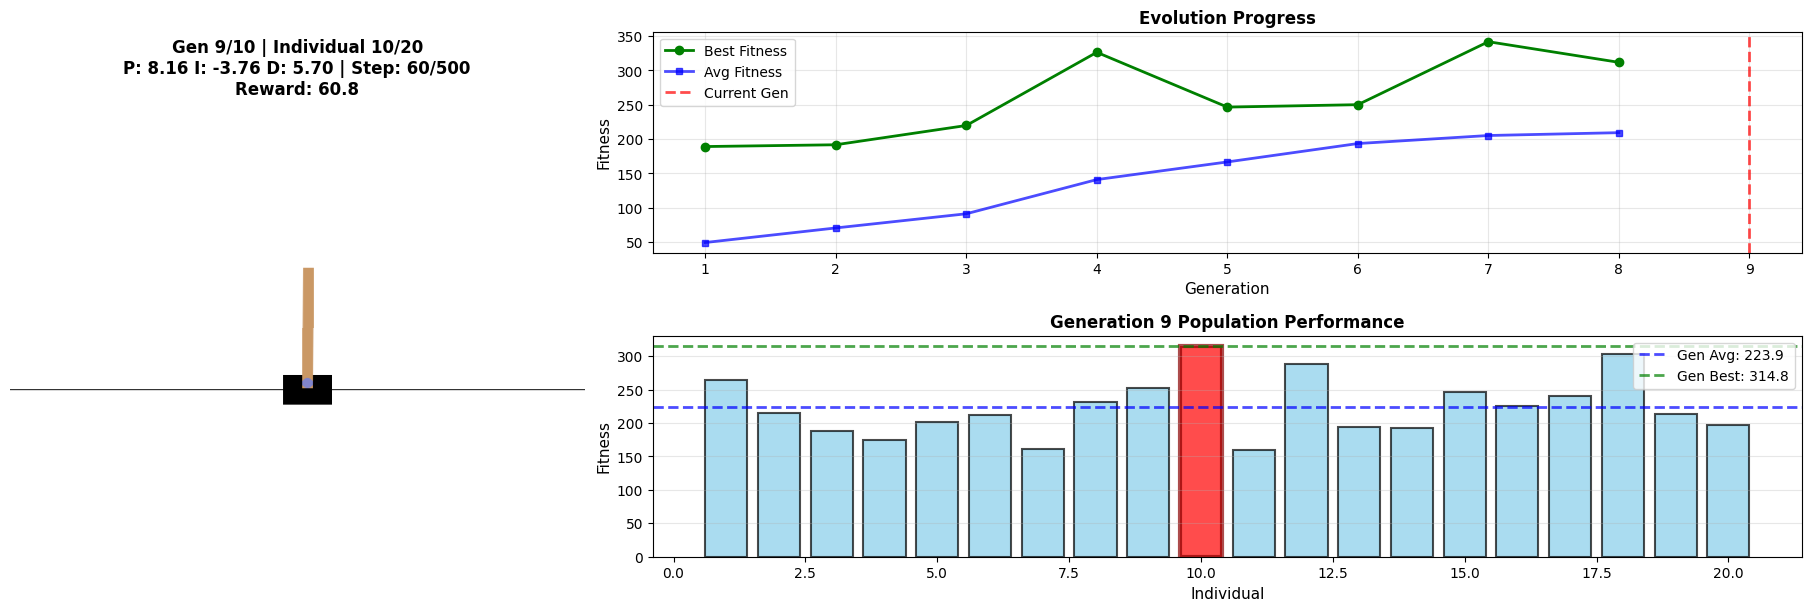


Generation 1/10
Best Fitness: 189.14, Avg Fitness: 49.43
Best PID: Kp=6.036, Ki=-3.801, Kd=4.443
------------------------------------------------------------

Generation 2/10
Best Fitness: 191.74, Avg Fitness: 70.62
Best PID: Kp=6.263, Ki=-3.801, Kd=5.844
------------------------------------------------------------

Generation 3/10
Best Fitness: 219.80, Avg Fitness: 91.26
Best PID: Kp=8.882, Ki=-6.605, Kd=5.844
------------------------------------------------------------

Generation 4/10
Best Fitness: 326.35, Avg Fitness: 141.05
Best PID: Kp=8.882, Ki=-3.801, Kd=5.844
------------------------------------------------------------

Generation 5/10
Best Fitness: 246.59, Avg Fitness: 166.74
Best PID: Kp=7.384, Ki=-3.572, Kd=7.787
------------------------------------------------------------

Generation 6/10
Best Fitness: 250.11, Avg Fitness: 193.53
Best PID: Kp=7.876, Ki=-3.801, Kd=5.844
------------------------------------------------------------

Generation 7/10
Best Fitness: 341.79, Avg 

In [ ]:

# Time to Run the Genetic Algorithm
print("\n" + "="*70)
print("STARTING GENETIC ALGORITHM")
print("="*70)

# Create GA instance using hyperparameters
ga = GeneticAlgorithm()

print(f"\nSearch Configuration:")
print(f"  Population: {ga.population_size} individuals")
print(f"  Generations: {ga.generations}")
print(f"  Parameter ranges: Kp{ga.kp_range}, Ki{ga.ki_range}, Kd{ga.kd_range}")
print(f"  Mutation: rate={MUTATION_RATE}, effect={MUTATION_EFFECT}")
print(f"  Crossover rate: {CROSSOVER_RATE}")
print(f"  Elitism: {ELITISM}")
print("="*70 + "\n")

best_pid, best_fitness = ga.evolve()

print("\n" + "=" * 60)
print("FINAL RESULTS")
print("=" * 60)
print(f"Best PID Parameters: Kp={best_pid[0]:.3f}, Ki={best_pid[1]:.3f}, Kd={best_pid[2]:.3f}")
print(f"Best Fitness (Average Reward): {best_fitness:.2f}")

# Plot the evolution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(ga.best_fitness_history, 'g-o', linewidth=2, markersize=8, label='Best Fitness')
plt.plot(ga.avg_fitness_history, 'b-s', linewidth=2, markersize=6, label='Average Fitness')
plt.xlabel('Generation', fontsize=12)
plt.ylabel('Fitness (Average Reward)', fontsize=12)
plt.title('Genetic Algorithm Evolution', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
improvement = np.array(ga.best_fitness_history) - ga.best_fitness_history[0]
plt.bar(range(1, len(improvement)+1), improvement, color='green', alpha=0.6, edgecolor='black')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Generation', fontsize=12)
plt.ylabel('Improvement from Gen 1', fontsize=12)
plt.title('Fitness Improvement Over Time', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 3D Fitness Landscape Visualization

This visualization shows the fitness of every individual across all generations. It's a great way to see:
- How the population spreads out initially (exploration)
- How it converges over time (exploitation)
- Which individuals dominated each generation
- Whether the population maintained diversity or got stuck

**What you're looking at:**
- X-axis: Individual number (1 to POPULATION_SIZE)
- Y-axis: Generation number
- Z-axis (height): Fitness score
- Colors: Fitness level (warmer = better)

**Patterns to look for:**
- **Steady climb:** Heights increase over generations = evolution working
- **Plateau:** Flat top = converged (or stuck in local optimum)
- **Wide spread:** Bars vary a lot = high diversity (good early, concerning late)
- **Narrow peaks:** All bars similar = low diversity (good if fitness is high, bad if it's low)
- **Single tall bar with low others:** Elitism keeping the best while exploring

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Create 3D fitness landscape
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')

# Prepare data
num_generations = len(ga.individual_fitness_history)
num_individuals = ga.population_size

# Create meshgrid for bar positions
xpos, ypos = np.meshgrid(np.arange(num_individuals), np.arange(num_generations))
xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros_like(xpos)

# Flatten fitness data for bar heights
fitness_data = np.array(ga.individual_fitness_history)
dz = fitness_data.flatten()

# Bar dimensions
dx = dy = 0.8

# Color mapping based on fitness (normalize to 0-1 range)
colors = plt.cm.viridis((dz - dz.min()) / (dz.max() - dz.min() + 1e-8))

# Create 3D bar chart
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=colors, shade=True, alpha=0.8)

# Labels and title
ax.set_xlabel('Individual', fontsize=12, labelpad=10)
ax.set_ylabel('Generation', fontsize=12, labelpad=10)
ax.set_zlabel('Fitness', fontsize=12, labelpad=10)
ax.set_title('Population Fitness Evolution: 3D Landscape\n' +
             f'Total Individuals: {num_individuals} | Generations: {num_generations}',
             fontsize=14, fontweight='bold', pad=20)

# Set better viewing angle
ax.view_init(elev=25, azim=-45)

# Add colorbar
mappable = plt.cm.ScalarMappable(cmap='viridis',
                                  norm=plt.Normalize(vmin=dz.min(), vmax=dz.max()))
mappable.set_array(dz)
cbar = plt.colorbar(mappable, ax=ax, shrink=0.6, aspect=10, pad=0.1)
cbar.set_label('Fitness Level', rotation=270, labelpad=20, fontsize=11)

# Grid for better depth perception
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print some statistics
print("="*70)
print("3D FITNESS LANDSCAPE STATISTICS")
print("="*70)
print(f"Total evaluations: {num_individuals * num_generations}")
print(f"Fitness range: {dz.min():.2f} to {dz.max():.2f}")
print(f"Overall improvement: {dz.max() - fitness_data[0].mean():.2f} ({((dz.max() - fitness_data[0].mean()) / fitness_data[0].mean() * 100):.1f}%)")
print(f"\nFirst generation - Mean: {fitness_data[0].mean():.2f}, Std: {fitness_data[0].std():.2f}")
print(f"Last generation  - Mean: {fitness_data[-1].mean():.2f}, Std: {fitness_data[-1].std():.2f}")
print(f"\nDiversity trend: {'Converging' if fitness_data[-1].std() < fitness_data[0].std() else 'Maintaining diversity'}")
print("="*70)

In [ ]:
# Demonstrate the best controller with visualization
print("Demonstrating the best PID controller...")
print(f"Using: Kp={best_pid[0]:.3f}, Ki={best_pid[1]:.3f}, Kd={best_pid[2]:.3f}")
print("\nWatch the CartPole balance below:")

# Run one episode with rendering
final_score = evaluate_pid(best_pid[0], best_pid[1], best_pid[2], render=True,
                             ga_instance=ga, current_gen=0,
                             current_individual=0)
print(f"\nFinal score: {final_score:.2f}")